<a href="https://colab.research.google.com/github/luciainnocenti/IncrementalLearning/blob/master/FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import GitHub repository

In [1]:
import os
import logging
import sys

In [2]:
if not os.path.isdir('./DatasetCIFAR'):
  !git clone https://github.com/luciainnocenti/IncrementalLearning.git
  !mv 'IncrementalLearning' 'DatasetCIFAR'

Cloning into 'IncrementalLearning'...
remote: Enumerating objects: 28, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 1527 (delta 15), reused 0 (delta 0), pack-reused 1499
Receiving objects: 100% (1527/1527), 1010.40 KiB | 3.47 MiB/s, done.
Resolving deltas: 100% (979/979), done.


# Import packages

In [3]:
from DatasetCIFAR.data_set import Dataset 
from DatasetCIFAR.data_set import Subset
from DatasetCIFAR import ResNet
from DatasetCIFAR import utils
from DatasetCIFAR import params
from torchvision import models
import torch.nn as nn
import torch
import torch.optim as optim
import torchvision
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.nn import functional as F
import random
random.seed(params.SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
print(params.SEED)
print(params.NUM_WORKERS)

653
4


# Define Network

In [5]:
resNet = ResNet.resnet32(num_classes=100)
resNet = resNet.to(params.DEVICE)

In [6]:

train_transformer = transforms.Compose([transforms.RandomCrop(size = 32, padding=4),
                                         transforms.RandomHorizontalFlip(),
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transformer = transforms.Compose([transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Define DataSets

In [7]:
trainDS = Dataset(train=True)
testDS = Dataset(train=False)

Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified


In [8]:
train_splits = trainDS.splits
test_splits = testDS.splits
print(train_splits)
print(test_splits)

[[94.0, 63.0, 74.0, 21.0, 35.0, 56.0, 91.0, 96.0, 87.0, 48.0], [68.0, 80.0, 22.0, 37.0, 60.0, 97.0, 51.0, 62.0, 92.0, 76.0], [75.0, 89.0, 23.0, 99.0, 39.0, 66.0, 54.0, 69.0, 84.0, 61.0], [85.0, 24.0, 98.0, 41.0, 73.0, 58.0, 78.0, 77.0, 70.0, 49.0], [65.0, 88.0, 36.0, 93.0, 45.0, 10.0, 90.0, 17.0, 32.0, 59.0], [83.0, 43.0, 53.0, 11.0, 86.0, 19.0, 38.0, 30.0, 40.0, 50.0], [57.0, 81.0, 12.0, 95.0, 25.0, 47.0, 34.0, 52.0, 44.0, 72.0], [46.0, 79.0, 20.0, 28.0, 5.0, 71.0, 8.0, 18.0, 33.0, 15.0], [55.0, 29.0, 64.0, 31.0, 67.0, 7.0, 13.0, 14.0, 42.0, 6.0], [82.0, 2.0, 27.0, 16.0, 26.0, 3.0, 4.0, 1.0, 9.0, 0.0]]
[[94.0, 63.0, 74.0, 21.0, 35.0, 56.0, 91.0, 96.0, 87.0, 48.0], [68.0, 80.0, 22.0, 37.0, 60.0, 97.0, 51.0, 62.0, 92.0, 76.0], [75.0, 89.0, 23.0, 99.0, 39.0, 66.0, 54.0, 69.0, 84.0, 61.0], [85.0, 24.0, 98.0, 41.0, 73.0, 58.0, 78.0, 77.0, 70.0, 49.0], [65.0, 88.0, 36.0, 93.0, 45.0, 10.0, 90.0, 17.0, 32.0, 59.0], [83.0, 43.0, 53.0, 11.0, 86.0, 19.0, 38.0, 30.0, 40.0, 50.0], [57.0, 81.0, 12.

# Useful plots

In [9]:
def plotTask(pars_tasks):

  x_tasks =  np.linspace(10, 100, 10)

  plt.plot(x_tasks, pars_tasks, label=['Accuracy', 'Loss'])
  plt.xlabel("Epoch")
  plt.title('Accuracy over tasks')
  plt.legend(['Accuracy', 'Loss'])
  plt.grid(True)
  plt.show()

In [10]:
def mapFunction(labels, splits):
	m_l = []
	l_splits = list(splits)
	for el in labels:
		m_l.append( l_splits.index(el) )
	return torch.LongTensor(m_l).to(params.DEVICE)

# Train and evaluation phase

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


At step  0  and at epoch =  0  the loss is =  0.02419709786772728  and accuracy is =  0.1876
At step  0  and at epoch =  1  the loss is =  0.025315560400485992  and accuracy is =  0.4014
At step  0  and at epoch =  2  the loss is =  0.017259353771805763  and accuracy is =  0.4832
At step  0  and at epoch =  3  the loss is =  0.026945650577545166  and accuracy is =  0.5234
At step  0  and at epoch =  4  the loss is =  0.028079917654395103  and accuracy is =  0.5368
At step  0  and at epoch =  5  the loss is =  0.016922106966376305  and accuracy is =  0.6038
At step  0  and at epoch =  6  the loss is =  0.014250035397708416  and accuracy is =  0.634
At step  0  and at epoch =  7  the loss is =  0.0223175548017025  and accuracy is =  0.6772
At step  0  and at epoch =  8  the loss is =  0.025830082595348358  and accuracy is =  0.6864
At step  0  and at epoch =  9  the loss is =  0.007626925595104694  and accuracy is =  0.7036
At step  0  and at epoch =  10  the loss is =  0.010720483027398

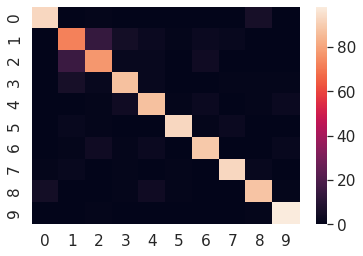

At step  10  and at epoch =  0  the loss is =  0.09140466153621674  and accuracy is =  0.193
At step  10  and at epoch =  1  the loss is =  0.058071307837963104  and accuracy is =  0.2468
At step  10  and at epoch =  2  the loss is =  0.03242584317922592  and accuracy is =  0.3098
At step  10  and at epoch =  3  the loss is =  0.031171534210443497  and accuracy is =  0.3716
At step  10  and at epoch =  4  the loss is =  0.023018421605229378  and accuracy is =  0.4184
At step  10  and at epoch =  5  the loss is =  0.026273565366864204  and accuracy is =  0.4524
At step  10  and at epoch =  6  the loss is =  0.022153712809085846  and accuracy is =  0.4892
At step  10  and at epoch =  7  the loss is =  0.020154790952801704  and accuracy is =  0.5056
At step  10  and at epoch =  8  the loss is =  0.019806398078799248  and accuracy is =  0.5318
At step  10  and at epoch =  9  the loss is =  0.026033081114292145  and accuracy is =  0.561
At step  10  and at epoch =  10  the loss is =  0.0223

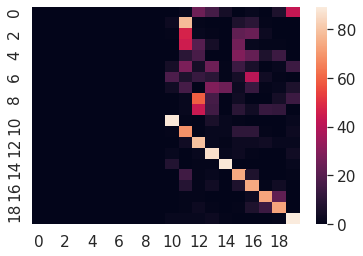

At step  20  and at epoch =  0  the loss is =  0.09079738706350327  and accuracy is =  0.151
At step  20  and at epoch =  1  the loss is =  0.057316284626722336  and accuracy is =  0.2224
At step  20  and at epoch =  2  the loss is =  0.03267459571361542  and accuracy is =  0.295
At step  20  and at epoch =  3  the loss is =  0.03536802530288696  and accuracy is =  0.3264
At step  20  and at epoch =  4  the loss is =  0.02277151308953762  and accuracy is =  0.3926
At step  20  and at epoch =  5  the loss is =  0.02341737225651741  and accuracy is =  0.5012
At step  20  and at epoch =  6  the loss is =  0.020933175459504128  and accuracy is =  0.5402
At step  20  and at epoch =  7  the loss is =  0.02811519056558609  and accuracy is =  0.5686
At step  20  and at epoch =  8  the loss is =  0.020986570045351982  and accuracy is =  0.5908
At step  20  and at epoch =  9  the loss is =  0.019077396020293236  and accuracy is =  0.6156
At step  20  and at epoch =  10  the loss is =  0.03105567

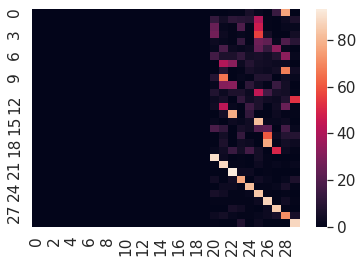

At step  30  and at epoch =  0  the loss is =  0.079085573554039  and accuracy is =  0.1104
At step  30  and at epoch =  1  the loss is =  0.055673740804195404  and accuracy is =  0.2222
At step  30  and at epoch =  2  the loss is =  0.03766603022813797  and accuracy is =  0.2846
At step  30  and at epoch =  3  the loss is =  0.02666720375418663  and accuracy is =  0.4136
At step  30  and at epoch =  4  the loss is =  0.02476496249437332  and accuracy is =  0.552
At step  30  and at epoch =  5  the loss is =  0.025930117815732956  and accuracy is =  0.6238
At step  30  and at epoch =  6  the loss is =  0.022806363180279732  and accuracy is =  0.6414
At step  30  and at epoch =  7  the loss is =  0.021443912759423256  and accuracy is =  0.6648
At step  30  and at epoch =  8  the loss is =  0.015915796160697937  and accuracy is =  0.6748
At step  30  and at epoch =  9  the loss is =  0.017926296219229698  and accuracy is =  0.6994
At step  30  and at epoch =  10  the loss is =  0.0205896

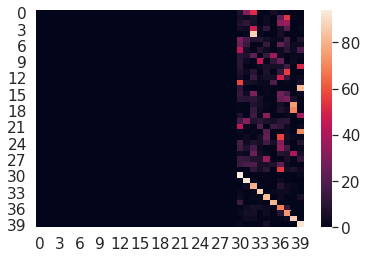

At step  40  and at epoch =  0  the loss is =  0.08150667697191238  and accuracy is =  0.1274
At step  40  and at epoch =  1  the loss is =  0.050561387091875076  and accuracy is =  0.2
At step  40  and at epoch =  2  the loss is =  0.03555247187614441  and accuracy is =  0.3202
At step  40  and at epoch =  3  the loss is =  0.032062310725450516  and accuracy is =  0.3498
At step  40  and at epoch =  4  the loss is =  0.035075582563877106  and accuracy is =  0.4064
At step  40  and at epoch =  5  the loss is =  0.031074199825525284  and accuracy is =  0.4812
At step  40  and at epoch =  6  the loss is =  0.029395481571555138  and accuracy is =  0.5216
At step  40  and at epoch =  7  the loss is =  0.026939991861581802  and accuracy is =  0.5584
At step  40  and at epoch =  8  the loss is =  0.023202652111649513  and accuracy is =  0.5756
At step  40  and at epoch =  9  the loss is =  0.024337271228432655  and accuracy is =  0.5898
At step  40  and at epoch =  10  the loss is =  0.02333

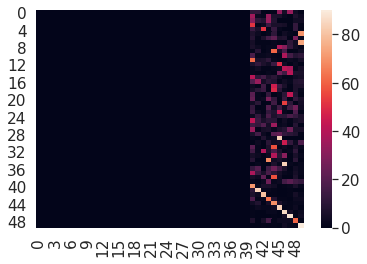

At step  50  and at epoch =  0  the loss is =  0.08232478052377701  and accuracy is =  0.1328
At step  50  and at epoch =  1  the loss is =  0.049917299300432205  and accuracy is =  0.2432
At step  50  and at epoch =  2  the loss is =  0.03229658678174019  and accuracy is =  0.2946
At step  50  and at epoch =  3  the loss is =  0.02591278962790966  and accuracy is =  0.3764
At step  50  and at epoch =  4  the loss is =  0.02687804214656353  and accuracy is =  0.4712
At step  50  and at epoch =  5  the loss is =  0.02169707790017128  and accuracy is =  0.5308
At step  50  and at epoch =  6  the loss is =  0.024108324199914932  and accuracy is =  0.5594
At step  50  and at epoch =  7  the loss is =  0.019715525209903717  and accuracy is =  0.5812
At step  50  and at epoch =  8  the loss is =  0.015811167657375336  and accuracy is =  0.6044
At step  50  and at epoch =  9  the loss is =  0.020476598292589188  and accuracy is =  0.6226
At step  50  and at epoch =  10  the loss is =  0.01578

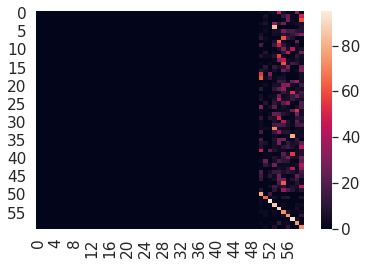

At step  60  and at epoch =  0  the loss is =  0.07533807307481766  and accuracy is =  0.1316
At step  60  and at epoch =  1  the loss is =  0.04757527634501457  and accuracy is =  0.2528
At step  60  and at epoch =  2  the loss is =  0.031206635758280754  and accuracy is =  0.3632
At step  60  and at epoch =  3  the loss is =  0.029963776469230652  and accuracy is =  0.4396
At step  60  and at epoch =  4  the loss is =  0.022486915811896324  and accuracy is =  0.5368
At step  60  and at epoch =  5  the loss is =  0.02506822533905506  and accuracy is =  0.5752
At step  60  and at epoch =  6  the loss is =  0.02048979327082634  and accuracy is =  0.6046
At step  60  and at epoch =  7  the loss is =  0.026613272726535797  and accuracy is =  0.6326
At step  60  and at epoch =  8  the loss is =  0.02110525593161583  and accuracy is =  0.6452
At step  60  and at epoch =  9  the loss is =  0.020817359909415245  and accuracy is =  0.6624
At step  60  and at epoch =  10  the loss is =  0.01882

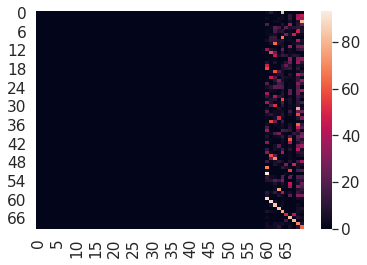

At step  70  and at epoch =  0  the loss is =  0.07971280813217163  and accuracy is =  0.1896
At step  70  and at epoch =  1  the loss is =  0.044970910996198654  and accuracy is =  0.335
At step  70  and at epoch =  2  the loss is =  0.03129711002111435  and accuracy is =  0.3828
At step  70  and at epoch =  3  the loss is =  0.022420959547162056  and accuracy is =  0.4602
At step  70  and at epoch =  4  the loss is =  0.025200650095939636  and accuracy is =  0.5632
At step  70  and at epoch =  5  the loss is =  0.027037834748625755  and accuracy is =  0.6068
At step  70  and at epoch =  6  the loss is =  0.020328249782323837  and accuracy is =  0.6366
At step  70  and at epoch =  7  the loss is =  0.016934223473072052  and accuracy is =  0.6558
At step  70  and at epoch =  8  the loss is =  0.01881583221256733  and accuracy is =  0.6804
At step  70  and at epoch =  9  the loss is =  0.027683112770318985  and accuracy is =  0.6966
At step  70  and at epoch =  10  the loss is =  0.0229

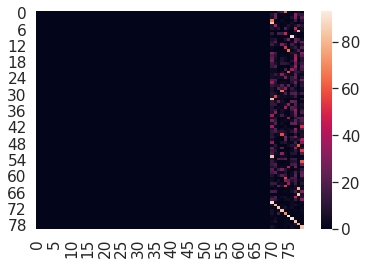

At step  80  and at epoch =  0  the loss is =  0.08586291968822479  and accuracy is =  0.1378
At step  80  and at epoch =  1  the loss is =  0.05688546225428581  and accuracy is =  0.239
At step  80  and at epoch =  2  the loss is =  0.02987605892121792  and accuracy is =  0.2566
At step  80  and at epoch =  3  the loss is =  0.039675988256931305  and accuracy is =  0.3154
At step  80  and at epoch =  4  the loss is =  0.02893221750855446  and accuracy is =  0.4062
At step  80  and at epoch =  5  the loss is =  0.025723299011588097  and accuracy is =  0.4592
At step  80  and at epoch =  6  the loss is =  0.02009139023721218  and accuracy is =  0.4944
At step  80  and at epoch =  7  the loss is =  0.02319740317761898  and accuracy is =  0.5112
At step  80  and at epoch =  8  the loss is =  0.017026370391249657  and accuracy is =  0.5402
At step  80  and at epoch =  9  the loss is =  0.02292197197675705  and accuracy is =  0.5498
At step  80  and at epoch =  10  the loss is =  0.02210338

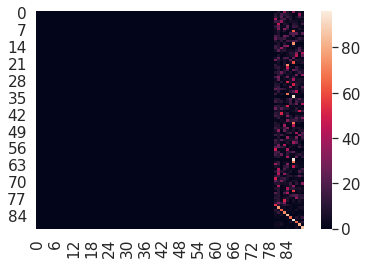

At step  90  and at epoch =  0  the loss is =  0.07598738372325897  and accuracy is =  0.1428
At step  90  and at epoch =  1  the loss is =  0.04642574116587639  and accuracy is =  0.2702
At step  90  and at epoch =  2  the loss is =  0.028447693213820457  and accuracy is =  0.3416
At step  90  and at epoch =  3  the loss is =  0.03486960753798485  and accuracy is =  0.4154
At step  90  and at epoch =  4  the loss is =  0.028613056987524033  and accuracy is =  0.522
At step  90  and at epoch =  5  the loss is =  0.020753657445311546  and accuracy is =  0.5572
At step  90  and at epoch =  6  the loss is =  0.01910163275897503  and accuracy is =  0.592
At step  90  and at epoch =  7  the loss is =  0.021030038595199585  and accuracy is =  0.625
At step  90  and at epoch =  8  the loss is =  0.017465833574533463  and accuracy is =  0.653
At step  90  and at epoch =  9  the loss is =  0.02410450018942356  and accuracy is =  0.6634
At step  90  and at epoch =  10  the loss is =  0.024056127

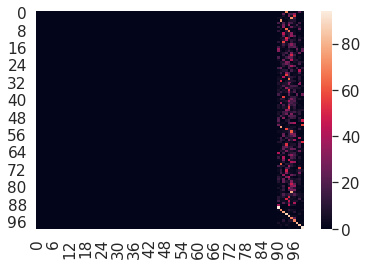

In [11]:
pars_tasks = []
test_indexes = []

for task in range(0, 100, params.TASK_SIZE):
  pars_tasks.insert(task, 0)


optimizer = torch.optim.SGD(resNet.parameters(), lr=params.LR, momentum=params.MOMENTUM, weight_decay=params.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, params.STEP_SIZE, gamma=params.GAMMA) #allow to change the LR at predefined epochs
criterion = torch.nn.BCEWithLogitsLoss()

current_step = 0


for task in range(0, 100, params.TASK_SIZE):

  train_indexes = trainDS.__getIndexesGroups__(task)
  test_indexes = test_indexes + testDS.__getIndexesGroups__(task)

  train_dataset = Subset(trainDS, train_indexes, train_transformer)
  test_dataset = Subset(testDS, test_indexes, test_transformer)

  train_loader = DataLoader( train_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True)
  test_loader = DataLoader( test_dataset, num_workers=params.NUM_WORKERS, batch_size=params.BATCH_SIZE, shuffle=True )
  
  col = np.array(train_splits[int(task/10)]).astype(int)
  
  for epoch in range (params.NUM_EPOCHS):
    lenght = 0
    scheduler.step() #update the learning rate
    running_corrects = 0    
    for images, labels, _ in train_loader:
      images = images.float().to(params.DEVICE)
      labels = labels.to(params.DEVICE)
      mappedLabels = mapFunction(labels, col)   
      onehot_labels = torch.eye(100)[labels].to(params.DEVICE)#it creates the one-hot-encoding list for the labels; needed for BCELoss    
      optimizer.zero_grad() # Zero-ing the gradients
      outputs = resNet(images)
      loss = criterion(outputs,onehot_labels)   
      cut_outputs = np.take_along_axis(outputs.to(params.DEVICE), col[None, :], axis = 1).to(params.DEVICE)
      _, preds = torch.max(cut_outputs.data, 1)
      running_corrects += torch.sum(preds == mappedLabels.data).data.item()   
      loss.backward()   
      optimizer.step()    
      current_step += 1
      lenght += len(images)   
    accuracy = running_corrects / float(lenght)
    print("At step ", str(task), " and at epoch = ", epoch, " the loss is = ", loss.item(), " and accuracy is = ", accuracy)
  
  resNet = resNet.eval()

  t_l = 0
  running_corrects = 0
  col = []
  for i,x in enumerate( test_splits[ :int(task/10) + 1]):
  	v = np.array(x)
  	col = np.concatenate( (col,v), axis = None)
  col = col.astype(int)

  tot_preds = []
  tot_lab = []
  for images, labels, _ in test_loader:
    images = images.float().to(params.DEVICE)
    labels = labels.to(params.DEVICE)   
    mappedLabels = mapFunction(labels, col)

    onehot_labels = torch.eye(100)[labels].to(params.DEVICE)

    outputs = resNet(images).to(params.DEVICE)
    cut_outputs = np.take_along_axis(outputs, col[None, :], axis = 1)
    cut_outputs = cut_outputs.to(params.DEVICE)
    _, preds = torch.max(cut_outputs.data, 1)
    tot_preds = np.concatenate( ( tot_preds, preds.data.cpu().numpy() ) )
    tot_lab = np.concatenate( (tot_lab, mappedLabels.data.cpu().numpy()  ) )
		# Update Corrects
    running_corrects += torch.sum(preds == mappedLabels.data).data.item()
    print(len(images))
    t_l += len(images)
  # Calculate Accuracy
  accuracy = running_corrects / float(t_l)
  loss = criterion(outputs,onehot_labels)
  print('Validation Loss: {} Validation Accuracy : {}'.format(loss.item(),accuracy) )
  cf = confusion_matrix(tot_lab, tot_preds)
  df_cm = pd.DataFrame(cf, range(task + params.TASK_SIZE), range(task + params.TASK_SIZE))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, annot=False)
  plt.show()
  pars_tasks[int(task/10)] = (accuracy, loss.item())
  resNet = resNet.train(True)
  
